**PROJECT 6:** *Classez des images à l'aide d'algorithmes de Deep Learning*

Goal: create an algorithm to detect the dog's breed on a picture

We had at our disposal the Stanford Dogs dataset. This dataset contains 20,580 pictures of 120 dog breeds.

From this data, I cleaned and preprocessed the dog pictures.

Then, I implemented a convolutional neural network (CNN) in order to classify these images:

- First I built a CNN, then I added layers of optimizations (dropout and batchnormalization) and I applied data augmentation.

- Then, I used Transfer Learning with optimization and data augmentation to train 3 models VGG16, ResNet50 and Xception.

Only the model with the best performance was used to classify the dog images.

The trainings were performed with Google Colab on GPU with a high RAM execution environment.

[Link Google colab Notebook](https://colab.research.google.com/drive/11kP-mOqigfnNRG7fwbhNJCMAXz0wXwT8#scrollTo=M0zJ4AQz_YQ7)

# I. Import the image data and the required libraries

### I.1. Connect to google drive and import all the required libraries

In [ ]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Import all the required librairies
!pip install -q keras
!pip install keras_tuner

import string 
import re
import pandas as pd
from scipy.io import loadmat
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import numpy as np
import shutil
import tarfile
from PIL import Image
from PIL import ImageOps 
from PIL import ImageFilter
from os import listdir
from os import makedirs
from os import mkdir
import seaborn as sns
import os
from numpy import load
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense
from keras.callbacks import EarlyStopping
from keras.applications.vgg16 import VGG16
from keras import Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import timeit
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from keras.applications.vgg16 import preprocess_input
from keras.utils import np_utils
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch, BayesianOptimization
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import img_to_array
from numpy import expand_dims
import kerastuner as kt
from kerastuner import RandomSearch
import tensorflow as tf 

In [ ]:
# Let's check the used GPU and all the file in my Drive
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print(f'- Found GPU at: {device_name}\n')

print('- My Drive:')
!ls "/content/drive/My Drive/"

- Found GPU at: /device:GPU:0

- My Drive:
'Agenda 2021.gsheet'   app		  P6_Image_Classification	  Thèse
 Analyses	      'Colab Notebooks'   Projet_6_Image_Classification


### I.2. Import data set from Stanford Dogs Dataset

In [ ]:
# Load all the files
!wget -cq http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
!wget -cq http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar
!wget -cq http://vision.stanford.edu/aditya86/ImageNetDogs/lists.tar

# Extract .tar files
import shutil
for my_file in ["images.tar", "annotation.tar", "lists.tar"]:
  shutil.unpack_archive(my_file, "/content/drive/My Drive/Projet_6_Image_Classification")

In [ ]:
# Explore the data
from torchvision.datasets import ImageFolder

data_dir = '/content/drive/My Drive/Projet_6_Image_Classification/Images'

myImages = ImageFolder(data_dir)
print('- Number of dog breed:', len(myImages.classes))
print('- List of the first 5 dog breed:\n', myImages.classes[:5])

- Number of dog breed: 120
- List of the first 5 dog breed:
 ['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu']


The size of the image Chihuahua: 
 Width: 461 px, Height: 500 px
 Pixel format: RGB
 Size of the pixel matrix (500, 461, 3)

The size of the image Japanese_spaniel: 
 Width: 414 px, Height: 298 px
 Pixel format: RGB
 Size of the pixel matrix (298, 414, 3)

The size of the image Maltese_dog: 
 Width: 300 px, Height: 295 px
 Pixel format: RGB
 Size of the pixel matrix (295, 300, 3)



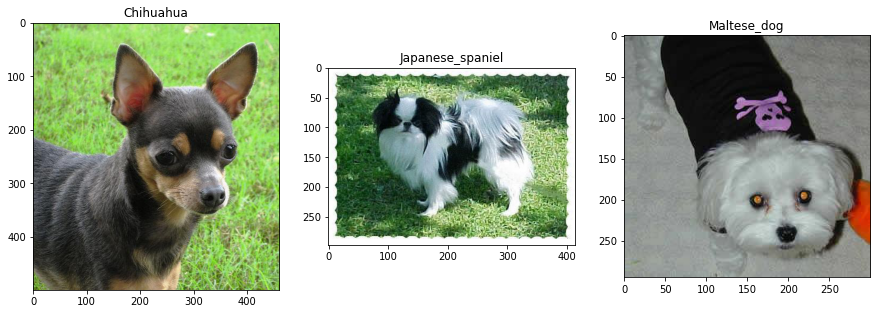

In [ ]:
# Displaying 3 images from the dataset
fig = plt.figure(figsize=(15, 11))

for i, j in zip([151,200,350], [1,2,3]):
    img, label = myImages[i]
    fig.add_subplot(1, 3, j)
    #plt.axis('off')
    plt.title(f"{myImages.classes[label].split('-')[-1]}") # split the name of dog breed 'n02085620-Chihuahua' on ('-') and keep the last part which is the dog name
    plt.imshow(img)


# Let's get some information about each of the 3 images
for i in [151,200,350]:
    img, label = myImages[i]
    w, h = img.size
    print(f"The size of the image {myImages.classes[label].split('-')[-1]}: \n Width: {w} px, Height: {h} px")
    print(f' Pixel format: {img.mode}')
    print(f' Size of the pixel matrix {np.array(img).shape}\n')

We can notice that these pictures have different size, shape, size of pixel matrix etc. In the next step I will clean and preprocess all the images

# II. Image preprocessing

### II.1. Create empty files for train and test set.

In [ ]:
# Create empty files for training set and testing set. Then in each file I will create empty files of each picture class (or breed)
N_pic = 0
list_dog_breeds = os.listdir('/content/drive/My Drive/Projet_6_Image_Classification/Images')

for i in list_dog_breeds:
    N_pic = N_pic +len(os.listdir('/content/drive/My Drive/Projet_6_Image_Classification/Images/' + i))


mkdir('/content/drive/My Drive/Projet_6_Image_Classification/Train_set')
mkdir('/content/drive/My Drive/Projet_6_Image_Classification/Test_set')

for files_ in listdir('/content/drive/My Drive/Projet_6_Image_Classification/Images'):
    makedirs('/content/drive/My Drive/Projet_6_Image_Classification/Train_set/' + files_, exist_ok=True)
    makedirs('/content/drive/My Drive/Projet_6_Image_Classification/Test_set/' + files_, exist_ok=True)

print(len(os.listdir('/content/drive/My Drive/Projet_6_Image_Classification/Train_set')))
print(len(os.listdir('/content/drive/My Drive/Projet_6_Image_Classification/Test_set')))

120
120


In [ ]:
# Path for train and test images from train_list.mat and test_list.mat
Train_list = loadmat('/content/drive/My Drive/Projet_6_Image_Classification/train_list.mat')['file_list'] # Path of all train images
Train_label = loadmat('/content/drive/My Drive/Projet_6_Image_Classification/train_list.mat')['labels'] # Label of all train images
Test_list = loadmat('/content/drive/My Drive/Projet_6_Image_Classification/test_list.mat')['file_list'] # Path of all test images
Test_label = loadmat('/content/drive/My Drive/Projet_6_Image_Classification/test_list.mat')['labels']  # Label of all test images


# Define a function to extract the name of the dog breed only
def dog_breed(row):
    Name = row['breed'][0].replace('/', ' ').split() # split the text
    Name = re.sub(r'[0-9]+', '', Name[0])[2:] # Just keep the dog breed from the title
    return Name


# Apply the function dog_breed on Train_list
breedname_train = pd.DataFrame(Train_list, columns=['breed'])
breedname_train['Name_extracted'] = breedname_train.apply(lambda row: dog_breed(row), axis=1)
print(f'Train_list\n{breedname_train.head(3)}\n\n')

# Apply the function dog_breed on Test_list
breedname_test = pd.DataFrame(Test_list, columns=['breed'])
breedname_test['Name_extracted'] = breedname_test.apply(lambda row: dog_breed(row), axis=1)
print(f'Test_list\n{breedname_test.head(3)}')

Train_list
                                      breed Name_extracted
0  [n02085620-Chihuahua/n02085620_5927.jpg]      Chihuahua
1  [n02085620-Chihuahua/n02085620_4441.jpg]      Chihuahua
2  [n02085620-Chihuahua/n02085620_1502.jpg]      Chihuahua


Test_list
                                      breed Name_extracted
0  [n02085620-Chihuahua/n02085620_2650.jpg]      Chihuahua
1  [n02085620-Chihuahua/n02085620_4919.jpg]      Chihuahua
2  [n02085620-Chihuahua/n02085620_1765.jpg]      Chihuahua


In [ ]:
# Number of images per dog breeds of both data set
print(f"Number of pictures/breeds (Train set): {breedname_train['Name_extracted'].value_counts().unique()}\n")# 100 images/breed
print(f"Number of pictures/breeds (Test set): {breedname_test['Name_extracted'].value_counts().unique()}") # images/breed is not homogenous. It's alrigth because it's the test set

Number of pictures/breeds (Train set): [100]

Number of pictures/breeds (Test set): [152 139 132 119 118 114 113 110 109 106 102 100  97  96  95  92  88  87
  86  85  84  83  82  81  80  79  78  75  72  71  70  69  68  67  64  61
  60  59  58  57  56  55  54  53  52  51  50  49  48]


Now I have my train set folder and test set folder. The next step will be to save the training images set in the training folder and the test images set in the test folder

### II.2. Save images (after preprossessing) in the Train_set and Test_set folder

In [ ]:
# Save cleaned images in the Train_set folder
n = 0
for image in Train_list:
    file_pic_train = '/content/drive/My Drive/Projet_6_Image_Classification/Images/' + image[0][0]
    img = Image.open(file_pic_train).convert('RGB') # Because the model turn on RGB and some pictures can be in RGBA format or other format
    img = img.resize((224, 224))
    img = ImageOps.equalize(img, mask = None)
    img = img.rotate(0, resample=Image.BILINEAR)
    img = img.filter(ImageFilter.BoxBlur(0))
    img.save('/content/drive/My Drive/Projet_6_Image_Classification/Train_set/' + image[0][0]) ## Save the cleaned training image in the train folder
    n=n+1
print(n, 'pictures saved in the Train_set file')


# Save cleaned images in the Test_set folder
n = 0
for image in Test_list:
    file_pic_test = '/content/drive/My Drive/Projet_6_Image_Classification/Images/' + image[0][0] 
    img = Image.open(file_pic_test).convert('RGB')
    img = img.resize((224, 224))
    img = ImageOps.equalize(img, mask = None)
    img = img.rotate(0, resample=Image.BILINEAR)
    img = img.filter(ImageFilter.BoxBlur(0)) 
    img.save('/content/drive/My Drive/Projet_6_Image_Classification/Test_set/' + image[0][0])## Save the cleaned test image in the test folder
    n=n+1
print(n, 'pictures saved in the Test_set file')

12000 pictures saved in the Train_set file
8580 pictures saved in the Test_set file


In [ ]:
# Training set as an array
images_train = []
n = 0
for image in Train_list:
    file_pic_train = '/content/drive/My Drive/Projet_6_Image_Classification/Train_set/' + image[0][0]
    img = Image.open(file_pic_train)
    n=n+1
    images_train.append(np.array(img))
images_train = np.array(images_train, dtype="uint8")
print('Train:',n)


# Test set as an array
images_test = []
n = 0
for image in Test_list:
    file_pic_test = '/content/drive/My Drive/Projet_6_Image_Classification/Test_set/' + image[0][0]
    img = Image.open(file_pic_test)
    n=n+1
    images_test.append(np.array(img))
images_test = np.array(images_test, dtype="uint8")
print('Test:', n)

Train: 12000
Test: 8580


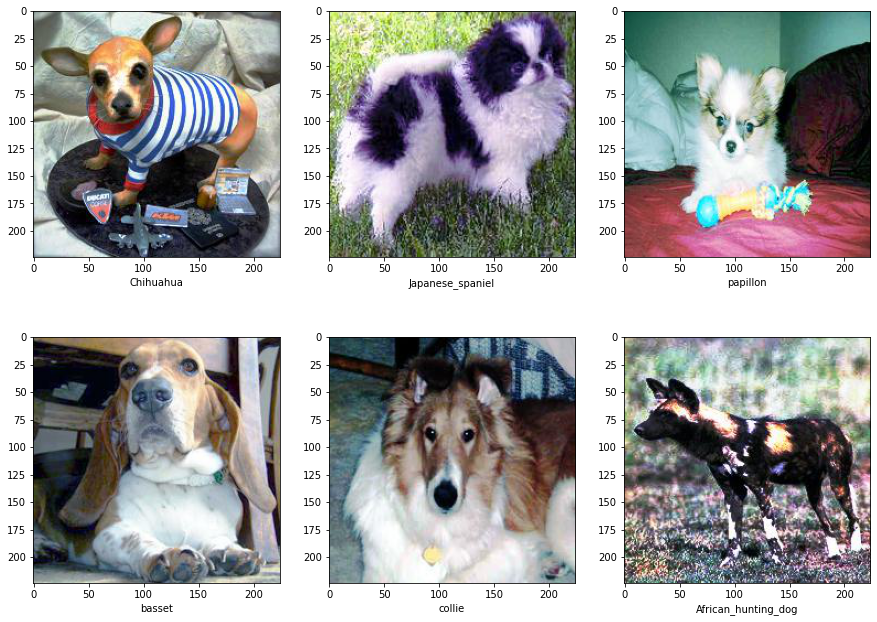

In [ ]:
# Displaying 6 images from the dataset Train
fig = plt.figure(figsize=(15, 11))

for i, j in zip([3,100,600,1001,8000,11999], [1,2,3,4,5,6]):
    fig.add_subplot(2, 3, j)
    #plt.axis('off')
    plt.imshow(images_train[i])
    plt.xlabel(breedname_train['Name_extracted'][i])

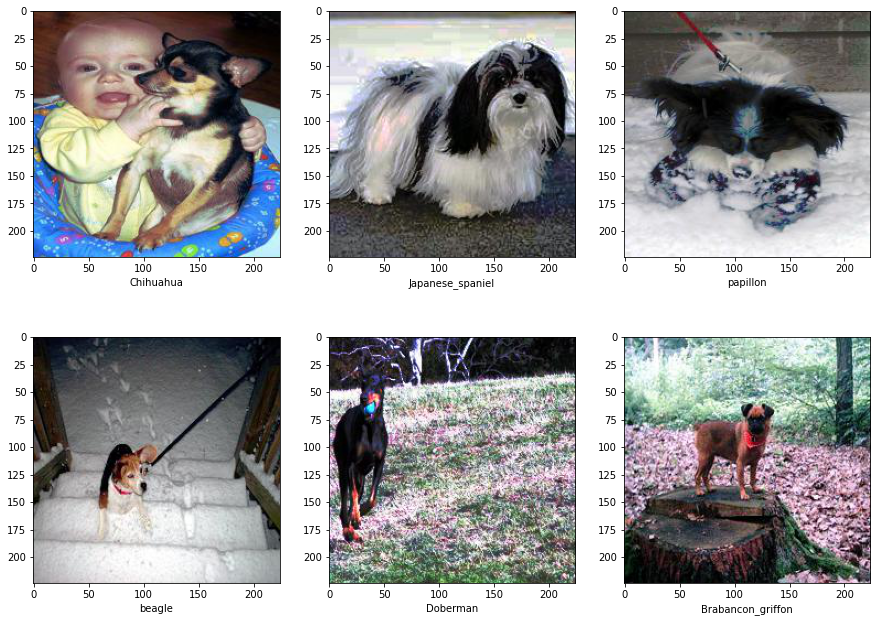

In [ ]:
# Displaying 6 images from the dataset Test
fig = plt.figure(figsize=(15, 11))

for i, j in zip([3,100,600,1001,6001,8000], [1,2,3,4,5,6]):
    fig.add_subplot(2, 3, j)
    #plt.axis('off')
    plt.imshow(images_test[i])
    plt.xlabel(breedname_test['Name_extracted'][i])

In the training set as well the testing set all the images are cleaned and preprocessed and they have the same size. In the next step I will train first CNN model and conclude on it's performance.

# III. Train a CNN model using Keras



### III.1. Training set and testing set

In [ ]:
## Create training set of 1000 images belonging to 10 different dog breed

images_train_ = images_train[:1000]
train_labels_ = Train_label[:1000]
images_test_ = images_test[:500]
test_labels_ = Test_label[:500]

print(images_train_.shape)
print(images_test_.shape)
print('='*50)
print(np.asarray(train_labels_).shape)
print(np.asarray(test_labels_).shape)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Normalise the data by dividing each pixel to 255 so that each pixel range will be between 0 and 1

X_train = images_train_.astype(np.float32)/255
X_test = images_test_.astype(np.float32)/255

encoder = LabelEncoder()
encoder.fit(train_labels_)
y_train = encoder.transform(train_labels_)
y_test = encoder.transform(test_labels_)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1000, 224, 224, 3)
(500, 224, 224, 3)
(1000,)
(500,)


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### III.2. CNN model

In [ ]:
def build_model(hp):
    model = keras.Sequential([
                        # Convolutinal layer
                        keras.layers.Conv2D(
                            filters=hp.Choice('conv_1_filter', values = [32, 64, 128]),
                            kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
                            activation='relu',
                            input_shape=(224, 224, 3)
                            ),

                        # Pooling layer
                        keras.layers.MaxPooling2D(
                            pool_size=hp.Choice('maxpool_1_size', values = [2, 3]),
                            strides=(2,2)
                            ),

                        # Fully connected layers
                        keras.layers.Flatten(),

                        keras.layers.Dense(
                            units=hp.Choice('dense_1_units', values = [32, 64, 128]),
                            activation='relu'
                            ),

                        keras.layers.Dense(10, activation='softmax')

                      ])
  
  
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values = [0.01, 0.001])),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  
    return model

  
# Search function
tuner_search=BayesianOptimization(build_model,
                          objective='val_accuracy',
                          max_trials=10,
                          directory='output',
                          project_name="P6_result_tuning_1")



# Run the function
start_time = timeit.default_timer()

tuner_search.search(X_train, y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=16) 

model = tuner_search.get_best_models(num_models=1)[0]

elapsed = timeit.default_timer() - start_time
print(f"Time: {round(elapsed/60,0)} min")
model.summary()

Trial 11 Complete [00h 01m 59s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 00h 14m 42s
INFO:tensorflow:Oracle triggered exit
Time: 15.0 min
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 109, 109, 64)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 760384)            0         
                                                                 
 dense (Dense)               (None, 64)                48664640  
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                      

In [ ]:
# Fit the model
history = model.fit(X_train, y_train,
                    epochs=100,
                    validation_split=0.2,
                    initial_epoch=50,
                    batch_size=16)
# list all data in history
print(history.history.keys())

Epoch 51/100
50/50 [==============================] - 2s 32ms/step - loss: 5.0897e-06 - accuracy: 1.0000 - val_loss: 51.3501 - val_accuracy: 0.0000e+00
Epoch 52/100
50/50 [==============================] - 1s 29ms/step - loss: 4.8530e-06 - accuracy: 1.0000 - val_loss: 51.4679 - val_accuracy: 0.0000e+00
Epoch 53/100
50/50 [==============================] - 1s 28ms/step - loss: 4.6299e-06 - accuracy: 1.0000 - val_loss: 51.6702 - val_accuracy: 0.0000e+00
Epoch 54/100
50/50 [==============================] - 1s 28ms/step - loss: 4.4152e-06 - accuracy: 1.0000 - val_loss: 51.8515 - val_accuracy: 0.0000e+00
Epoch 55/100
50/50 [==============================] - 1s 28ms/step - loss: 4.2134e-06 - accuracy: 1.0000 - val_loss: 52.0189 - val_accuracy: 0.0000e+00
Epoch 56/100
50/50 [==============================] - 1s 28ms/step - loss: 4.0270e-06 - accuracy: 1.0000 - val_loss: 52.2045 - val_accuracy: 0.0000e+00
Epoch 57/100
50/50 [==============================] - 1s 28ms/step - loss: 3.8534e-06 - 

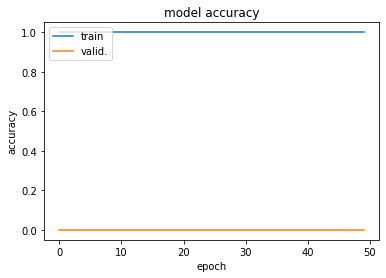

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid.'], loc='upper left')
plt.show()

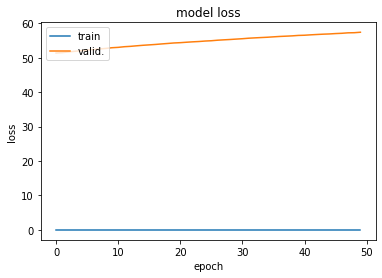

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid.'], loc='upper left')
plt.show()

In [ ]:
# Model evaluation on test data
model.evaluate(X_test, y_test) # The accuarcy is low

16/16 [==============================] - 0s 21ms/step - loss: 5.0715 - accuracy: 0.2100


[5.071489334106445, 0.20999999344348907]

We can conclude that the model overfitted quickly (train_accuracy=1) and can hardly predict the category of the images. Moreover, the training of the model will cost a lot of time and memory by training it over 12000 images instead of 1000.

Indeed, the memory and time consumption to find the optimal number of layers and the optimal hyperparameters are large. **For this, I decided to optimize the model by recontructing the layers of an already known model which is VGG16 model.**

# IV. Reconstruct a VGG16 model

VGG16 is a convolutional neural network model proposed by K. Simonyan and A. Zisserman from the University of Oxford in the paper “Very Deep Convolutional Networks for Large-Scale Image Recognition”.

See below the strcture of VGG16:

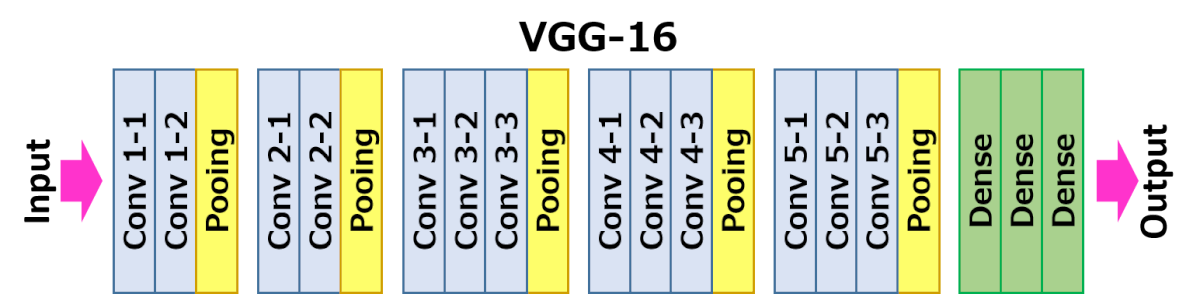

### IV.1. Prepare the data for the VGG16 model


The ImageDataGenerator will automatically label all the data inside each category folder as the corresponding category. In this way data is easily ready to be passed to the neural network.

In [ ]:
# Training set generator
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

print('\nTraining set:')
train_data = train_datagen.flow_from_directory('/content/drive/My Drive/Projet_6_Image_Classification/Train_set', 
                                           target_size=(224, 224), 
                                           color_mode='rgb',
                                           batch_size=32,
                                           shuffle=True, 
                                           class_mode='categorical',
                                           subset = 'training')


Training set:
Found 9600 images belonging to 120 classes.


In [ ]:
# Validation set generator
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

print('\nValidation set:')
val_data = val_datagen.flow_from_directory('/content/drive/My Drive/Projet_6_Image_Classification/Train_set', 
                                           target_size=(224, 224), 
                                           color_mode='rgb',
                                           batch_size=32,
                                           shuffle=True,
                                           class_mode='categorical',
                                           subset = 'validation')


Validation set:
Found 2400 images belonging to 120 classes.


In [ ]:
# Test set generator
test_datagen = ImageDataGenerator(rescale=1./255)

print('\nTest set:')
test_data = test_datagen.flow_from_directory(directory="/content/drive/My Drive/Projet_6_Image_Classification/Test_set",
                                      target_size=(224,224),
                                      color_mode='rgb',
                                      batch_size=32,
                                      class_mode="categorical")


Test set:
Found 8580 images belonging to 120 classes.


### IV.2. Reconstruct layers of VGG16

VGG16 have a convolution layers of 3x3 filter with a stride 1 and always used same padding and maxpool layer of 2x2 filter of stride 2. It follows this arrangement of convolution and max pool layers consistently throughout the whole architecture. In the end it has 2 fully connected layers followed by a softmax for output.

In [ ]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Here, I add relu (Rectified Linear Unit) activation to each layers
# so that all the negative values are not passed to the next layer.
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


# Here, I pass the data to the dense layer so for that I flatten the vector which comes out 
# of the convolutions and add 2 Dense layers of 4096 units each and 1 Dense Softmax layer of 120 units (= the number of dog breeds)
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=120, activation="softmax"))


# After the creation of softmax layer the model is finally prepared. Now I need to compile the model.
model.compile(optimizer='Adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
model.summary()

### IV.3. Train the model

- ModelCheckpoint helps us to save the model by monitoring a specific parameter of the model.
In this case I am monitoring validation accuracy by passing val_acc to ModelCheckpoint. 
The model will only be saved to disk if the validation accuracy of the model in current epoch is greater than what it was in the last epoch.

- EarlyStopping helps us to stop the training of the model early if there is no increase in the parameter which I have set to monitor in EarlyStopping. 
In this case I am monitoring validation accuracy by passing val_acc to EarlyStopping. 
I have here set patience to 20 which means that the model will stop to train if it doesn’t see any rise in validation accuracy in 20 epochs.

In [ ]:
# Define model checkpoint and earlystopping

checkpoint = ModelCheckpoint("vgg16_1.h5",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='max')

early = EarlyStopping(monitor='val_accuracy',
                      patience=20,
                      verbose=1,
                      mode='max',
                      restore_best_weights=True)

In [ ]:
# Let's train the model
start_time = timeit.default_timer()

batch_size = 64
hist = model.fit_generator(steps_per_epoch=9600//batch_size,  #train set lenth // batch size
                           generator=train_data,
                           validation_data= val_data,
                           validation_steps=2400//batch_size,  #validation set lenth // batch size
                           epochs=100,
                           callbacks=[checkpoint,early])

elapsed = timeit.default_timer() - start_time
print(f"Time: {round(elapsed/60,0)} min")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/100
150/150 [==============================] - ETA: 0s - loss: 4.8323 - accuracy: 0.0085 
Epoch 1: val_accuracy improved from -inf to 0.01098, saving model to vgg16_1.h5
150/150 [==============================] - 3611s 24s/step - loss: 4.8323 - accuracy: 0.0085 - val_loss: 4.7874 - val_accuracy: 0.0110
Epoch 2/100
150/150 [==============================] - ETA: 0s - loss: 4.7884 - accuracy: 0.0075
Epoch 2: val_accuracy did not improve from 0.01098
150/150 [==============================] - 1741s 12s/step - loss: 4.7884 - accuracy: 0.0075 - val_loss: 4.7876 - val_accuracy: 0.0059
Epoch 3/100
150/150 [==============================] - ETA: 0s - loss: 4.7879 - accuracy: 0.0075
Epoch 3: val_accuracy did not improve from 0.01098
150/150 [==============================] - 892s 6s/step - loss: 4.7879 - accuracy: 0.0075 - val_loss: 4.7872 - val_accuracy: 0.0093
Epoch 4/100
150/150 [==============================] - ETA: 0s - loss: 4.7881 - accuracy: 0.0071
Epoch 4: val_accuracy did not

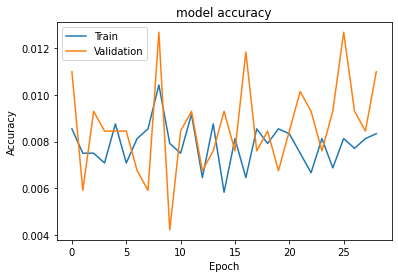

In [ ]:
# Model accuracy
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])

plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train","Validation"])
plt.show()

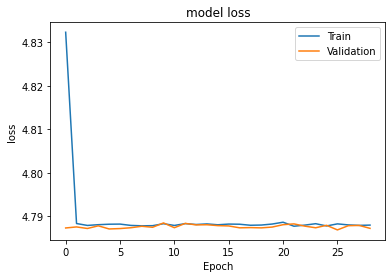

In [ ]:
# Model loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("Epoch")
plt.legend(["Train","Validation"])
plt.show()

The model stopped after 28 epochs. We can note that after the 10th epoch the accuarcy didin't improve and the loss has not been minimized.

In [ ]:
# Model performance on new data (test data)
start_time = timeit.default_timer()

batch_size = 64
model_eval = model.evaluate(test_data, steps=8580//batch_size)
print(f"Test loss, Test accuracy: {model_eval}")

elapsed = timeit.default_timer() - start_time
print(f"Time: {round(elapsed/60,0)} min")

134/134 [==============================] - 2641s 20s/step - loss: 4.7879 - accuracy: 0.0070
Test loss, Test accuracy: [4.787918567657471, 0.00699626887217164]
Time: 45.0 min


The model has difficulty in predicting the category of new images. It has a very low accuracy on testing set.

# V. Add bacth normalization and dropout layers on VGG16 model

- "Batch normalization is a technique for training deep neural networks that standardizes the inputs to a layer for each mini-batch. This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks."
[Jason Brownlee (2019) in Deep Learning Performance](https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/#:~:text=Batch%20normalization%20is%20a%20technique,required%20to%20train%20deep%20networks.)

- During training, some number of layer outputs are randomly ignored or “dropped out.”  This is called dropout and offers a very computationally cheap and remarkably effective regularization method to reduce overfitting and improve generalization error in deep neural networks of all kinds. [Jason Brownlee (2018) in Deep Learning Performance](https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/)

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)#I can pick any number try with 1234
np.random.seed(42)# Idem 1234

In [ ]:
model2 = Sequential()
model2.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model2.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model2.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model2.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model2.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model2.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model2.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

# Add batch normalization and dropout layers
model2.add(Flatten())
model2.add(Dropout(0.3)) # To avoid overfiting by dropping out 30% of layers output  

model2.add(Dense(units=4096,activation="relu"))
model2.add(BatchNormalization())
model2.add(Dropout(0.3))

model2.add(Dense(units=4096,activation="relu"))
model2.add(BatchNormalization())
model2.add(Dropout(0.3))

model2.add(Dense(units=120, activation="softmax"))

In [ ]:
model2.compile(optimizer='Adam',
               loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

In [ ]:
# Define model checkpoint and earlystopping

checkpoint = ModelCheckpoint("vgg16_2.h5",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='max')

early = EarlyStopping(monitor='val_accuracy',
                      patience=20,
                      verbose=1,
                      mode='max',
                      restore_best_weights=True)

In [ ]:
start_time = timeit.default_timer()

batch_size = 64
hist = model2.fit_generator(steps_per_epoch=9600//batch_size,  #train set lenth // batch size
                           generator=train_data,
                           validation_data= val_data,
                           validation_steps=2400//batch_size,  #validation set lenth // batch size
                           epochs=100,
                           callbacks=[checkpoint,early])

elapsed = timeit.default_timer() - start_time
print(f"Time: {round(elapsed/60,0)} min")

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


150/150 [==============================] - ETA: 0s - loss: 7.0840 - accuracy: 0.0100
Epoch 1: val_accuracy improved from -inf to 0.00760, saving model to vgg16_2_optimization.h5
150/150 [==============================] - 45s 288ms/step - loss: 7.0840 - accuracy: 0.0100 - val_loss: 677.2110 - val_accuracy: 0.0076
Epoch 2/100
150/150 [==============================] - ETA: 0s - loss: 7.0297 - accuracy: 0.0088
Epoch 2: val_accuracy improved from 0.00760 to 0.01014, saving model to vgg16_2_optimization.h5
150/150 [==============================] - 44s 295ms/step - loss: 7.0297 - accuracy: 0.0088 - val_loss: 15.5535 - val_accuracy: 0.0101
Epoch 3/100
150/150 [==============================] - ETA: 0s - loss: 7.0028 - accuracy: 0.0117
Epoch 3: val_accuracy did not improve from 0.01014
150/150 [==============================] - 39s 258ms/step - loss: 7.0028 - accuracy: 0.0117 - val_loss: 5.9442 - val_accuracy: 0.0059
Epoch 4/100
150/150 [==============================] - ETA: 0s - loss: 6.957

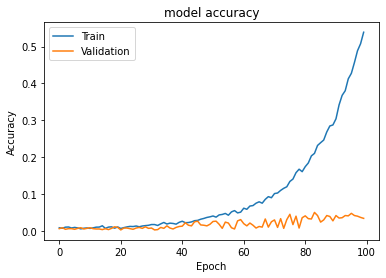

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])

plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train","Validation"])
plt.show()

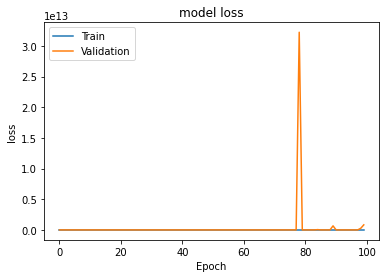

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("Epoch")
plt.legend(["Train","Validation"])
plt.show()

In [ ]:
# Model performance on new data (test data)
start_time = timeit.default_timer()

model_eval = model2.evaluate(test_data, steps=8580//batch_size)
print(f"Test loss, Test accuracy: {model_eval}")

elapsed = timeit.default_timer() - start_time
print(f"Time: {round(elapsed/60,0)} min")

134/134 [==============================] - 1326s 10s/step - loss: 2323903152128.0000 - accuracy: 0.0473
Test loss, Test accuracy: [2323903152128.0, 0.04734141752123833]
Time: 22.0 min


The model still has difficulty in predicting the images of the test set. The accuracy is still very low. The absence of the model improvement may be due to the fact that I have only 100 pictures/class. Thus, in order to avoid overfitting I will apply a data augmentation.

# VI. Data augmentation

Image data augmentation is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset. [Jason Brownlee (2019) in Deep Learning for Computer Vision](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/)

### VI.1. Let's try some type of data augmentation one by one.

The Keras deep learning library provides the ability to use data augmentation automatically when training a model. This is achieved by using the ImageDataGenerator() 

In [ ]:
# load a ranom image from data set
img = myImages[326][0]

data = img_to_array(img) # convert to numpy array

samples = expand_dims(data, 0) # expand dimension to one sample

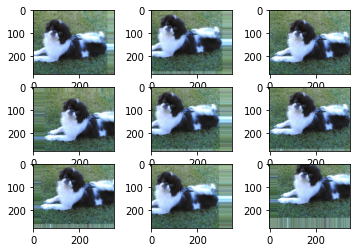

In [ ]:
# Horizontal and Vertical Shift transformation

# create image data augmentation generator
datagen = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2)

# prepare iterator
it = datagen.flow(samples)

# generate samples and plot
for i in range(9):
    plt.subplot(330 + 1 + i) # define subplot
    batch = it.next() # generate batch of images
    image = batch[0].astype('uint8') # convert to unsigned integers for viewing
    plt.imshow(image) # plot raw pixel data

# show the figure
plt.show()

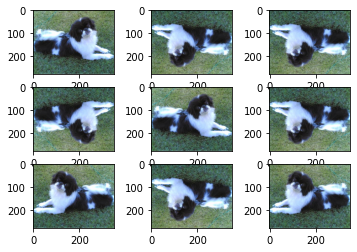

In [ ]:
# Horizontal and Vertical Flip transformation
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
it = datagen.flow(samples)

for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = it.next()
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

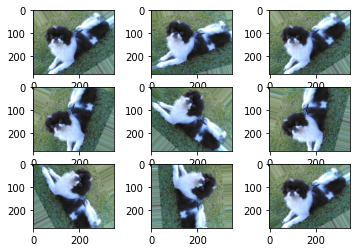

In [ ]:
# Random Rotation transformation
datagen = ImageDataGenerator(rotation_range=90)
it = datagen.flow(samples)

for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = it.next()
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

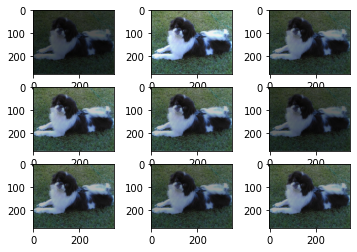

In [ ]:
# Random Brightness transformation
datagen = ImageDataGenerator(brightness_range=[0.3,1])
it = datagen.flow(samples)

for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = it.next()
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

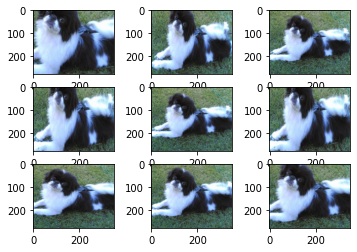

In [ ]:
# Random Zoom Augmentation
datagen = ImageDataGenerator(zoom_range=[0.5,1.0])
it = datagen.flow(samples)

for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = it.next()
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

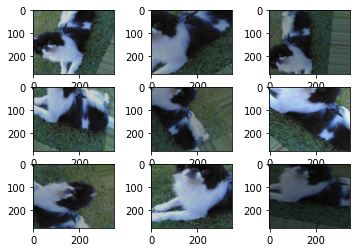

In [ ]:
# The above transformation all together
datagen = ImageDataGenerator(width_shift_range=0.2, 
                             height_shift_range=0.2,
                             rotation_range=90,
                             brightness_range=[0.2,1],
                             zoom_range=[0.5,1.0])

it = datagen.flow(samples)

for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = it.next()
    image = batch[0].astype('uint8')
    plt.imshow(image)

# show the figure
plt.show()

In [ ]:
# Training set generator with data augmentation

# Let's define a function to generate training set with data augmentation
train_datagen = ImageDataGenerator(rescale=1./255, 
                                            zca_whitening = False,         
                                            rotation_range = 30,
                                            width_shift_range = 0.1,
                                            height_shift_range = 0.1,
                                            horizontal_flip=True,
                                            shear_range=0.2,
                                            zoom_range=0.2,
                                            brightness_range=[0.6, 1.2],
                                            validation_split=0.2)


print('\nTraining set:')
train_data_augment = train_datagen.flow_from_directory('/content/drive/My Drive/Projet_6_Image_Classification/Train_set', 
                                           target_size=(224, 224), 
                                           color_mode='rgb',
                                           batch_size=32,
                                           shuffle=True, 
                                           class_mode='categorical',
                                           subset = 'training')


Training set:
Found 9600 images belonging to 120 classes.


In [ ]:
# Validation set generator
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

print('\nValidation set:')
val_data_augment = val_datagen.flow_from_directory('/content/drive/My Drive/Projet_6_Image_Classification/Train_set', 
                                           target_size=(224, 224), 
                                           color_mode='rgb',
                                           batch_size=32,
                                           shuffle=True,
                                           class_mode='categorical',
                                           subset = 'validation')


Validation set:
Found 2400 images belonging to 120 classes.


In [ ]:
# Test set generator
test_datagen = ImageDataGenerator(rescale=1./255)

print('\nTest set:')
test_data = test_datagen.flow_from_directory(directory="/content/drive/My Drive/Projet_6_Image_Classification/Test_set",
                                      target_size=(224,224),
                                      color_mode='rgb',
                                      batch_size=32,
                                      class_mode="categorical")

- Images from training set:



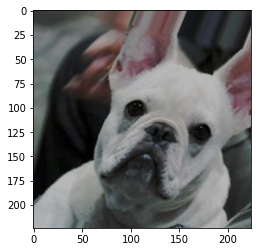

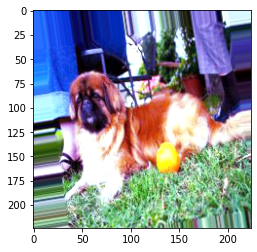

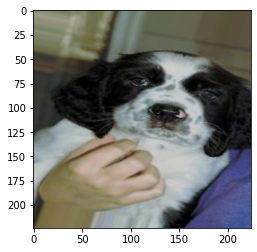


- Images from test set:


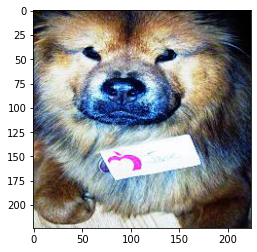

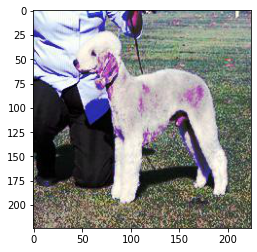

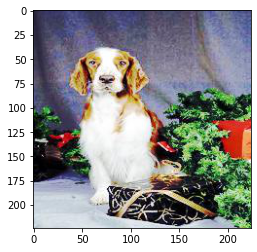

In [ ]:
# Show some images
def getSamplesFromDataGen(resultData):
    x = resultData.next() #fetch the first batch
    a = x[0] # train data
    for i in range(0,3):
        plt.imshow(a[i])
        plt.show()

print('- Images from training set:')
getSamplesFromDataGen(train_data_augment)
print('\n\n- Images from test set:')
getSamplesFromDataGen(test_data)

### VI.2. Train the model

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
model3 = Sequential()
model3.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model3.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model3.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model3.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model3.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model3.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model3.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model3.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model3.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model3.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model3.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model3.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model3.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model3.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model3.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model3.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model3.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model3.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

# Add batch normalization and dropout layers
model3.add(Flatten())
model3.add(Dropout(0.3))

model3.add(Dense(units=4096,activation="relu"))
model3.add(BatchNormalization())
model3.add(Dropout(0.3))

model3.add(Dense(units=4096,activation="relu"))
model3.add(BatchNormalization())
model3.add(Dropout(0.3))

model3.add(Dense(units=120, activation="softmax"))

In [ ]:
model3.compile(optimizer='Adam', # I should try with 'rmsprop'
               loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

In [ ]:
# Define model checkpoint and earlystopping

checkpoint = ModelCheckpoint("vgg16_3.h5",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='max')

early = EarlyStopping(monitor='val_accuracy',
                      patience=20,
                      verbose=1,
                      mode='max',
                      restore_best_weights=True)

In [ ]:
start_time = timeit.default_timer()
batch_size = 64

hist = model3.fit_generator(steps_per_epoch=9600//batch_size,  #train set lenth // batch size
                           generator=train_data_augment,
                           validation_data= val_data_augment,
                           validation_steps=2400//batch_size,  #train set lenth // batch size
                           epochs=100,
                           callbacks=[checkpoint,early])

elapsed = timeit.default_timer() - start_time
print(f"Time: {round(elapsed/60,0)} min")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/100
150/150 [==============================] - ETA: 0s - loss: 6.9316 - accuracy: 0.0119
Epoch 1: val_accuracy improved from -inf to 0.01182, saving model to vgg16_2_augment.h5
150/150 [==============================] - 79s 495ms/step - loss: 6.9316 - accuracy: 0.0119 - val_loss: 98.9471 - val_accuracy: 0.0118
Epoch 2/100
150/150 [==============================] - ETA: 0s - loss: 6.9748 - accuracy: 0.0106
Epoch 2: val_accuracy did not improve from 0.01182
150/150 [==============================] - 68s 452ms/step - loss: 6.9748 - accuracy: 0.0106 - val_loss: 10.0826 - val_accuracy: 0.0101
Epoch 3/100
150/150 [==============================] - ETA: 0s - loss: 6.7105 - accuracy: 0.0100
Epoch 3: val_accuracy did not improve from 0.01182
150/150 [==============================] - 68s 450ms/step - loss: 6.7105 - accuracy: 0.0100 - val_loss: 10.3548 - val_accuracy: 0.0101
Epoch 4/100
150/150 [==============================] - ETA: 0s - loss: 6.6873 - accuracy: 0.0098
Epoch 4: val_accu

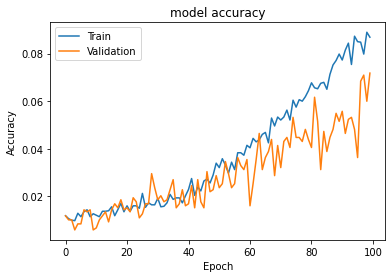

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])

plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train","Validation"])
plt.show()

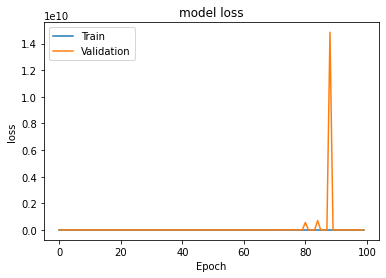

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("Epoch")
plt.legend(["Train","Validation"])
plt.show()

In [ ]:
# Model performance on test data
start_time = timeit.default_timer()

model_eval = model3.evaluate(test_data, steps=8580//batch_size)
print(f"Test loss, Test accuracy: {model_eval}")

elapsed = timeit.default_timer() - start_time
print(f"Time: {round(elapsed/60,0)} min")

134/134 [==============================] - 667s 5s/step - loss: 248.9979 - accuracy: 0.0781
Test loss, Test accuracy: [248.9978790283203, 0.078125]
Time: 11.0 min


Even after the data augmentation the model can hardly predict the category of the images. That's why I'm going to test the transfer learning method.

# VII. Transfer learning

### VII.1. VGG16

I will use the strategy of features extraction.
- To do so, I will remove the last fully-connected layer and set all other parameters. This truncated network will then compute the representation of each input image from the features already learned during the pre-training.

- Thus, it is important to freeze the convolutional base before compiling and training the model. Freezing (by setting layer.trainable = False) prevents the weights of a given layer from being updated during training.

- I will add 3 dropout layers and 3 fully connected top layer (the classifier included)

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
# Training set generator with data augmentation
train_datagen = ImageDataGenerator(zca_whitening = False,         
                                            rotation_range = 30,
                                            width_shift_range = 0.1,
                                            height_shift_range = 0.1,
                                            horizontal_flip=True,
                                            shear_range=0.2,
                                            zoom_range=0.2,
                                            brightness_range=[0.6, 1.2],
                                            preprocessing_function=preprocess_input,
                                            validation_split=0.2)


print('\nTraining set:')
train_data_augment = train_datagen.flow_from_directory('/content/drive/My Drive/Projet_6_Image_Classification/Train_set', 
                                           target_size=(224, 224), 
                                           color_mode='rgb',
                                           batch_size=32,
                                           shuffle=True, 
                                           class_mode='categorical',
                                           subset = 'training')

# Validation set generator
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)

print('\nValidation set:')
val_data_augment = val_datagen.flow_from_directory('/content/drive/My Drive/Projet_6_Image_Classification/Train_set', 
                                           target_size=(224, 224), 
                                           color_mode='rgb',
                                           batch_size=32,
                                           shuffle=True,
                                           class_mode='categorical',
                                           subset = 'validation')


# Test set generator
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

print('\nTest set:')
test_data = test_datagen.flow_from_directory(directory="/content/drive/My Drive/Projet_6_Image_Classification/Test_set",
                                      target_size=(224,224),
                                      color_mode='rgb',
                                      batch_size=32,
                                      class_mode="categorical")


Training set:
Found 9600 images belonging to 120 classes.

Validation set:
Found 2400 images belonging to 120 classes.

Test set:
Found 8580 images belonging to 120 classes.


In [ ]:
## Loading VGG16 model
base_model = VGG16(weights="imagenet",
                   include_top=False, # To remove the classification layer that was trained on the ImageNet dataset
                   input_shape=(224,224,3))

for layer in base_model.layers:
    layer.trainable = False

# Add Batch Normalization, dropout layers and fully connected layers
Layers = keras.layers.Flatten()(base_model.output)
Layers = keras.layers.Dropout(0.3)(Layers)

Layers = keras.layers.Dense(4096, activation='relu')(Layers)
Layers = keras.layers.BatchNormalization()(Layers)
Layers = keras.layers.Dropout(0.3)(Layers)

Layers = keras.layers.Dense(4096, activation='relu')(Layers)
Layers = keras.layers.BatchNormalization()(Layers)
Layers = keras.layers.Dropout(0.3)(Layers)

predictions = keras.layers.Dense(120, activation = 'softmax')(Layers)

model_vgg16 = keras.Model(inputs=base_model.input, outputs=predictions)

model_vgg16.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
model_vgg16.compile(optimizer='Adam',
               loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [ ]:
# Create a folder called final_models to save the training models 
final_model_path = os.path.join("/content/drive/My Drive/Projet_6_Image_Classification", "final_models")
os.makedirs(final_model_path, exist_ok=True)
vgg16_path = final_model_path + "/vgg16_tr_learning.h5"

In [ ]:
checkpoint = ModelCheckpoint(filepath=vgg16_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='max')

early = EarlyStopping(monitor='val_accuracy',
                      patience=20,
                      verbose=1,
                      mode='max',
                      restore_best_weights=True)

In [ ]:
# Fit the model
start_time = timeit.default_timer()
batch_size = 64

hist = model_vgg16.fit_generator(steps_per_epoch=9600//batch_size,
                           generator=train_data_augment,
                           validation_data= val_data_augment,
                           validation_steps=2400//batch_size,
                           epochs=100,
                           callbacks=[checkpoint,early])

elapsed = timeit.default_timer() - start_time
print(f"Time: {round(elapsed/60,0)} min")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/100
150/150 [==============================] - ETA: 0s - loss: 5.6682 - accuracy: 0.1325
Epoch 1: val_accuracy improved from -inf to 0.24324, saving model to /content/drive/My Drive/Projet_6_Image_Classification/final_models/vgg16_tr_learning.h5
150/150 [==============================] - 1303s 9s/step - loss: 5.6682 - accuracy: 0.1325 - val_loss: 9.6769 - val_accuracy: 0.2432
Epoch 2/100
150/150 [==============================] - ETA: 0s - loss: 4.2746 - accuracy: 0.2752
Epoch 2: val_accuracy improved from 0.24324 to 0.31334, saving model to /content/drive/My Drive/Projet_6_Image_Classification/final_models/vgg16_tr_learning.h5
150/150 [==============================] - 679s 5s/step - loss: 4.2746 - accuracy: 0.2752 - val_loss: 6.4629 - val_accuracy: 0.3133
Epoch 3/100
150/150 [==============================] - ETA: 0s - loss: 3.9956 - accuracy: 0.3177
Epoch 3: val_accuracy improved from 0.31334 to 0.38598, saving model to /content/drive/My Drive/Projet_6_Image_Classification/f

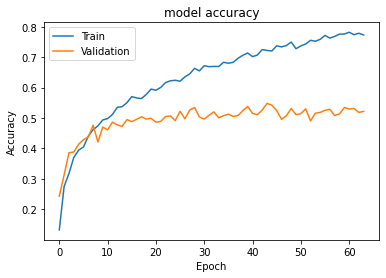

In [ ]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])

plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train","Validation"])
plt.show()

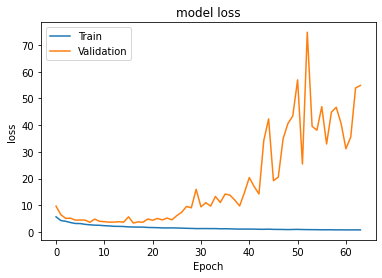

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("Epoch")
plt.legend(["Train","Validation"])
plt.show()

In [ ]:
# Evaluate the model
start_time = timeit.default_timer()

model_eval = model_vgg16.evaluate(test_data, steps=8580//batch_size)
print(f"Test loss, Test accuracy: {model_eval}")

elapsed = timeit.default_timer() - start_time
print(f"Time: {round(elapsed/60,0)} min")

134/134 [==============================] - 884s 7s/step - loss: 31.9573 - accuracy: 0.5315
Test loss, Test accuracy: [31.95731544494629, 0.5314832329750061]
Time: 15.0 min


The accuracy increased with transfer learning using VGG16. We can note an improvement of the prediction of the images on the test data set with an accuracy of 50%.

Let's try to further optimize the model by using another convolutional neural network, ResNet-50.

### VII.2. ResNet-50

ResNet-50 is a convolutional neural network that is 50 layers deep(48 Convolution layers along with 1 MaxPool and 1 Average Pool layer). It is an innovative neural network that was first introduced by Kaiming He et *al.* in their 2015 computer vision research paper titled ‘Deep Residual Learning for Image Recognition’. ([click here for more details](https://viso.ai/deep-learning/resnet-residual-neural-network/))

- For ResNet50, I will apply the same logic as VGG16.

- I will remove the top layer and I will add a GlobalAveragePooling2D() layer to to reduce the dimension of the images and 2 dropout layers and 2 fully connected top layer (the classifier included)



In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
# Training set generator with data augmentation
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, 
                                            zca_whitening = False,         
                                            rotation_range = 30,
                                            width_shift_range = 0.1,
                                            height_shift_range = 0.1,
                                            horizontal_flip=True,
                                            shear_range=0.2,
                                            zoom_range=0.2,
                                            brightness_range=[0.6, 1.2],
                                            validation_split=0.2)


print('\nTraining set:')
train_data_augment = train_datagen.flow_from_directory('/content/drive/My Drive/Projet_6_Image_Classification/Train_set', 
                                           target_size=(224, 224), 
                                           color_mode='rgb',
                                           batch_size=32,
                                           shuffle=True, 
                                           class_mode='categorical',
                                           subset = 'training')

# Validation set generator
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)

print('\nValidation set:')
val_data_augment = val_datagen.flow_from_directory('/content/drive/My Drive/Projet_6_Image_Classification/Train_set', 
                                           target_size=(224, 224), 
                                           color_mode='rgb',
                                           batch_size=32,
                                           shuffle=True,
                                           class_mode='categorical',
                                           subset = 'validation')

# Test set generator
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

print('\nTest set:')
test_data = test_datagen.flow_from_directory(directory="/content/drive/My Drive/Projet_6_Image_Classification/Test_set",
                                      target_size=(224,224),
                                      color_mode='rgb',
                                      batch_size=32,
                                      class_mode="categorical")


Training set:
Found 9600 images belonging to 120 classes.

Validation set:
Found 2400 images belonging to 120 classes.

Test set:
Found 8580 images belonging to 120 classes.


In [ ]:
base_model = ResNet50(include_top=False, # To remove the classification layer that was trained on the ImageNet dataset
                  input_shape = (224,224,3),
                  weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

Layers = keras.layers.GlobalAveragePooling2D()(base_model.output)
Layers = keras.layers.Dropout(0.3)(Layers) # Regularize with dropout

Layers = keras.layers.Dense(2048, activation='relu')(Layers)
Layers = keras.layers.Dropout(0.3)(Layers)

predictions = keras.layers.Dense(120, activation = 'softmax')(Layers)

resnet_model = keras.Model(inputs=base_model.input, outputs=predictions)

resnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
resnet_model.compile(optimizer='Adam', 
               loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [ ]:
resnet50_path = final_model_path + "/resnet_tr_learning.h5"

checkpoint = ModelCheckpoint(filepath=resnet50_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='max')

early = EarlyStopping(monitor='val_accuracy',
                      patience=20,
                      verbose=1,
                      mode='max',
                      restore_best_weights=True)

In [ ]:
start_time = timeit.default_timer()

batch_size = 64

hist = resnet_model.fit_generator(steps_per_epoch=9600//batch_size,
                           generator=train_data_augment,
                           validation_data= val_data_augment,
                           validation_steps=2400//batch_size,
                           epochs=100,
                           callbacks=[checkpoint,early])

elapsed = timeit.default_timer() - start_time
print(f"Time: {round(elapsed/60,0)} min")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/100
150/150 [==============================] - ETA: 0s - loss: 3.5950 - accuracy: 0.2135
Epoch 1: val_accuracy improved from -inf to 0.45101, saving model to /content/drive/My Drive/Projet_6_Image_Classification/final_models/resnet_tr_learning.h5
150/150 [==============================] - 180s 1s/step - loss: 3.5950 - accuracy: 0.2135 - val_loss: 1.9530 - val_accuracy: 0.4510
Epoch 2/100
150/150 [==============================] - ETA: 0s - loss: 2.2092 - accuracy: 0.4115
Epoch 2: val_accuracy improved from 0.45101 to 0.58699, saving model to /content/drive/My Drive/Projet_6_Image_Classification/final_models/resnet_tr_learning.h5
150/150 [==============================] - 140s 933ms/step - loss: 2.2092 - accuracy: 0.4115 - val_loss: 1.4539 - val_accuracy: 0.5870
Epoch 3/100
150/150 [==============================] - ETA: 0s - loss: 1.9581 - accuracy: 0.4677
Epoch 3: val_accuracy improved from 0.58699 to 0.61571, saving model to /content/drive/My Drive/Projet_6_Image_Classificati

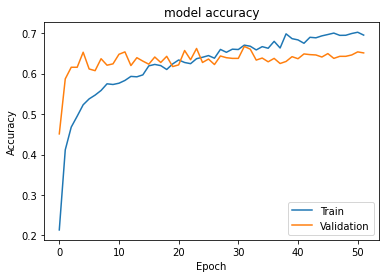

In [ ]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])

plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train","Validation"])
plt.show()

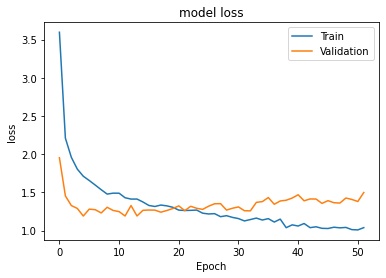

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("Epoch")
plt.legend(["Train","Validation"])
plt.show()

In [ ]:
# Evaluate the model
start_time = timeit.default_timer()

model_eval = resnet_model.evaluate(test_data, steps=8580//batch_size)
print(f"Test loss, Test accuracy: {model_eval}")

elapsed = timeit.default_timer() - start_time
print(f"Time: {round(elapsed/60,0)} min")

134/134 [==============================] - 2729s 21s/step - loss: 1.3660 - accuracy: 0.6423
Test loss, Test accuracy: [1.3659653663635254, 0.6422574520111084]
Time: 46.0 min


The accuracy has improved. However, I will try to improve it even more by training anotherconvolutional neural network model, Xception.

### VII.3. Xception

Xception is a deep convolutional neural network architecture that involves Depthwise Separable Convolutions. It was developed by Google researchers. [click here for more details](https://maelfabien.github.io/deeplearning/xception/#)

I will remove the top layer and I will add a GlobalAveragePooling2D() layer to to reduce the dimension of the images and 2 dropout layers and 2 fully connected top layer (the classifier included)

In [ ]:
from tensorflow.keras.applications.xception import Xception, preprocess_input

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
# Training set generator with data augmentation
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, 
                                            zca_whitening = False,         
                                            rotation_range = 30,
                                            width_shift_range = 0.1,
                                            height_shift_range = 0.1,
                                            horizontal_flip=True,
                                            shear_range=0.2,
                                            zoom_range=0.2,
                                            brightness_range=[0.6, 1.2],
                                            validation_split=0.2)


print('\nTraining set:')
train_data_augment = train_datagen.flow_from_directory('/content/drive/My Drive/Projet_6_Image_Classification/Train_set', 
                                           target_size=(224, 224), 
                                           color_mode='rgb',
                                           batch_size=32,
                                           shuffle=True, 
                                           class_mode='categorical',
                                           subset = 'training')


# Validation set generator
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)

print('\nValidation set:')
val_data_augment = val_datagen.flow_from_directory('/content/drive/My Drive/Projet_6_Image_Classification/Train_set', 
                                           target_size=(224, 224), 
                                           color_mode='rgb',
                                           batch_size=32,
                                           shuffle=True,
                                           class_mode='categorical',
                                           subset = 'validation')


# Test set generator
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

print('\nTest set:')
test_data = test_datagen.flow_from_directory(directory="/content/drive/My Drive/Projet_6_Image_Classification/Test_set",
                                      target_size=(224,224),
                                      color_mode='rgb',
                                      batch_size=32,
                                      class_mode="categorical")


Training set:
Found 9600 images belonging to 120 classes.

Validation set:
Found 2400 images belonging to 120 classes.

Test set:
Found 8580 images belonging to 120 classes.


In [ ]:
base_model = Xception(include_top=False,
                  input_shape = (299,299,3),
                  weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

num_classes = 120
Layers = keras.layers.BatchNormalization()(base_model.output)
Layers = keras.layers.GlobalAveragePooling2D()(Layers)
Layers = keras.layers.Dropout(0.3)(Layers)
Layers = keras.layers.Dense(1024, activation='relu')(Layers)
Layers = keras.layers.Dropout(0.3)(Layers)

predictions = keras.layers.Dense(num_classes, activation='softmax')(Layers)

xception_model = keras.Model(inputs=base_model.input, outputs=predictions)

xception_model.summary()

83697664/83683744 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                      

In [ ]:
xception_model.compile(optimizer='Adam', 
               loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [ ]:
xception_path = final_model_path + "/xception_tr_learning.h5"

checkpoint = ModelCheckpoint(filepath=xception_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='max')

early = EarlyStopping(monitor='val_accuracy',
                      patience=20,
                      verbose=1,
                      mode='max',
                      restore_best_weights=True)

In [ ]:
start_time = timeit.default_timer()

batch_size = 64

hist = xception_model.fit_generator(steps_per_epoch=9600//batch_size,
                           generator=train_data_augment,
                           validation_data= val_data_augment,
                           validation_steps=2400//batch_size,
                           epochs=100,
                           callbacks=[checkpoint,early])

elapsed = timeit.default_timer() - start_time
print(f"Time: {round(elapsed/60,0)} min")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/100
150/150 [==============================] - ETA: 0s - loss: 2.3700 - accuracy: 0.4552
Epoch 1: val_accuracy improved from -inf to 0.65287, saving model to /content/drive/My Drive/Projet_6_Image_Classification/final_models/xception_tr_learning.h5
150/150 [==============================] - 1678s 11s/step - loss: 2.3700 - accuracy: 0.4552 - val_loss: 1.2926 - val_accuracy: 0.6529
Epoch 2/100
150/150 [==============================] - ETA: 0s - loss: 1.8147 - accuracy: 0.5646
Epoch 2: val_accuracy improved from 0.65287 to 0.68159, saving model to /content/drive/My Drive/Projet_6_Image_Classification/final_models/xception_tr_learning.h5
150/150 [==============================] - 851s 6s/step - loss: 1.8147 - accuracy: 0.5646 - val_loss: 1.2577 - val_accuracy: 0.6816
Epoch 3/100
150/150 [==============================] - ETA: 0s - loss: 1.6758 - accuracy: 0.5844
Epoch 3: val_accuracy did not improve from 0.68159
150/150 [==============================] - 462s 3s/step - loss: 1.675

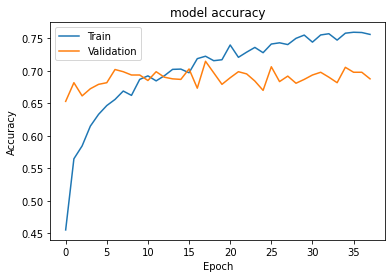

In [ ]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])

plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train","Validation"])
plt.show()

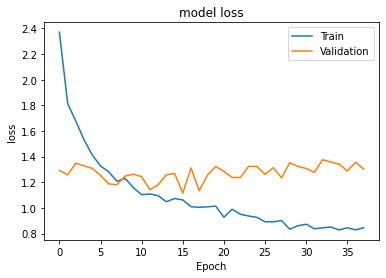

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("Epoch")
plt.legend(["Train","Validation"])
plt.show()

In [ ]:
start_time = timeit.default_timer()

model_eval = xception_model.evaluate(test_data, steps=8580//batch_size)
print(f"Test loss, Test accuracy: {model_eval}")

elapsed = timeit.default_timer() - start_time
print(f"Time: {round(elapsed/60,0)} min")

134/134 [==============================] - 1122s 8s/step - loss: 1.2088 - accuracy: 0.7045
Test loss, Test accuracy: [1.20881187915802, 0.7045242786407471]
Time: 19.0 min


Xception has the best accuracy (around 70%) and it is this model that will be chosen to predict new images

### VII.4. Save the models and the list of dog breed

In [ ]:
import pickle

# Save the list of dog breed
dog_breed=[]
for i in myImages.classes:
  dog_breed.append(i.split('-')[-1]) # Cleaning the list (only the breed without the numbers)

filename = '/content/drive/My Drive/Projet_6_Image_Classification/final_models/breed_list.pkl'
pickle.dump(dog_breed, open(filename, 'wb'))


# Save the 3 models
model_vgg16.save(vgg16_path)
resnet_model.save(resnet50_path)
xception_model.save(xception_path)

In [ ]:
# Download the chosen model (Xception) from Google Collab on my local disk
from google.colab import files

files.download("/content/drive/My Drive/Projet_6_Image_Classification/final_models/xception_tr_learning.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# VIII. Prediction

The predicted dog breed is : Chihuahua (probability: 0.7312122583389282)


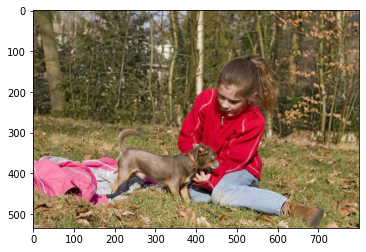

In [ ]:
from keras.models import load_model
from  keras.preprocessing import image
from keras.applications.xception import preprocess_input, decode_predictions
from PIL import Image
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load the saved model
my_model = tf.keras.models.load_model("/content/drive/My Drive/Projet_6_Image_Classification/final_models/xception_tr_learning.h5")

# Load the list of dog breed
import pickle
with open('/content/drive/My Drive/Projet_6_Image_Classification/final_models/breed_list.pkl', 'rb') as f:
  dog_breed = pickle.load(f)

# Image path
image_path = '/content/drive/My Drive/Projet_6_Image_Classification/Images/n02085620-Chihuahua/n02085620_806.jpg'

# Clean and preprocess the image
img = image.load_img(image_path)
img_cleaned = img.resize((299,299), Image.ANTIALIAS) # Image.ANTIALIAS to have a clear image
img_cleaned = image.img_to_array(img_cleaned)
img_cleaned = np.expand_dims(img_cleaned, axis=0)
img_cleaned = preprocess_input(img_cleaned)
plt.imshow(img) # show the original image


# Define a function to predit the dog breed and the corresponding probability
def predict(img, dog_breed_list):
  preds = my_model.predict(img_cleaned)
  pred_label =  dog_breed_list[np.argmax(preds)] # predict the dog breed
  pred_proba =  np.max(preds[0]) # predict it's corresponding probability
  
  print(f"The predicted dog breed is : {pred_label} (probability: {pred_proba})")


# Apply the prediction
prediction = predict(img_cleaned, dog_breed)